In [1]:
pip install transformers datasets evaluate accelerate

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/84.1 kB ? eta -:--:--
   ------------------- -------------------- 41.0/84.1 kB ? eta -:--:--
   -------------------------------------- - 81.9/84.1 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 84.1/84.1 kB 677.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/290.1 kB ? eta -:--:--
   --------------- ------------------------ 112.6/290.1 kB 6.8 MB/s eta 0:00:01
   ------------------------------- -------- 225.3/290.1 kB 3.5 MB/s eta 0:00:01
   ----------------------------------- ---- 256.0/290.1 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------  286.7/290.1 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 290.1/290.1 kB 1.6 MB/s eta 0:00:00



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
pip install protobuf==3.20.*

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [1]:
from datasets import load_dataset
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
df_file=r"./data/all_data_us_IsraelSentimentTweet__updated_to_2024-02-20__16_33.xlsx"
full_tweets_df = pd.read_excel(df_file)
full_tweets_df['upload_date'] = pd.to_datetime(full_tweets_df['upload_date'])
new_twits = full_tweets_df[full_tweets_df['upload_date'] >= '2023-11-15']
tweets_df_unprocessed = new_twits[["post_text", "conflict_sentiment"]]
tweets_df_unprocessed.columns = ["text", "label"]

In [4]:
# drop NaN
tweets_df = tweets_df_unprocessed.copy(deep=True)
tweets_df.dropna(inplace=True)
# Convert conflict_sentiment to numeric
tweets_df['label'] = pd.to_numeric(tweets_df['label'], errors='coerce')
# Convert conflict_sentiment values which are different than 0 to 1
tweets_df['label'] = tweets_df['label'].apply(lambda x: 0 if x == 0 else 1)

### Automatic train test split

In [5]:
test_frac = 0.2

tweets_df_0 = tweets_df[tweets_df["label"] == 0]
tweets_df_1 = tweets_df[tweets_df["label"] == 1]

len_label_0 = len(tweets_df_0)
len_label_1 = len(tweets_df_1)

test_1 = int(test_frac*len_label_1)
train_1 = len_label_1 - test_1
if len_label_0 >= 4*len_label_1:
    train_0 = 4*train_1
    test_0 = 4*test_1
else:
    test_0 = int(test_frac*len_label_0)
    train_0 = len_label_0 - test_0

In [6]:
# train_0 = 12000
# test_0 = 8000
# train_1 = 3000
# test_1 = 1985

seed_value = 42

train_df_0 = tweets_df_0[:-test_0]
train_df_0 = train_df_0.sample(n=train_0, random_state=seed_value)
test_df_0 = tweets_df_0[-test_0:]
train_df_1 = tweets_df_1[:-test_1]
train_df_1 = train_df_1.sample(n=train_1, random_state=seed_value)
test_df_1 = tweets_df_1[-test_1:]

train_df = pd.concat([train_df_0, train_df_1], ignore_index=True)
test_df = pd.concat([test_df_0, test_df_1], ignore_index=True)
len_label_0, len_label_1

(77162, 4985)

In [7]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)
ds = DatasetDict()
ds['train'] = train_ds.shuffle(seed=42)
ds['test'] = test_ds

In [8]:
train_df['label'].value_counts()

label
0    15952
1     3988
Name: count, dtype: int64

In [9]:
test_df['label'].value_counts()

label
0    3988
1     997
Name: count, dtype: int64

In [10]:
ds['train'][6]

{'text': 'RT @AndrewJBates46: .@PressSec: "The organization that is stopping [the pause] is Hamas."\n\n"Israel has asked for a list of these women whoÃƒÂ¢Ã¢â€šÂ¬Ã‚Â¦',
 'label': 1}

### Training

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")

C:\Users\yehoshd\Anaconda3\envs\gpu_env\Lib\site-packages\transformers\convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [12]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=1024)

In [13]:
tokenized_ds = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/19940 [00:00<?, ? examples/s]

Map:   0%|          | 0/4985 [00:00<?, ? examples/s]

In [14]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
import evaluate

accuracy = evaluate.load("accuracy")

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision_0 = precision_score(labels, preds, pos_label=0, average='binary')
    recall_0 = recall_score(labels, preds, pos_label=0, average='binary')
    precision_1 = precision_score(labels, preds, pos_label=1, average='binary')
    recall_1 = recall_score(labels, preds, pos_label=1, average='binary')

    f1 = f1_score(labels, preds, average='average')

    return {
        'accuracy': accuracy,
        'precision_0': precision_0,
        'recall_0': recall_0,
        'precision_1': precision_1,
        'recall_1': recall_1,
        'f1': f1
    }

In [17]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

id2label,label2id

({0: 'NEGATIVE', 1: 'POSITIVE'}, {'NEGATIVE': 0, 'POSITIVE': 1})

In [18]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [65]:
model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large',
    num_labels=2, id2label=id2label, label2id=label2id,

)
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

In [19]:
#load a trained model
trained_model = AutoModelForSequenceClassification.from_pretrained('yehoshuadiller/twitter_classification_newest',
    num_labels=2, id2label=id2label, label2id=label2id,

)
trained_model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

In [20]:
training_args = TrainingArguments(
    output_dir="twitter_classification",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)

NameError: name 'model' is not defined

In [22]:
trainer.train()

wandb: Currently logged in as: ydiller (nomorenms). Use `wandb login --relogin` to force relogin


RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

### Evaluation

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'all_preds': preds,
        'all_labels': labels,
        'raw_preds': pred.predictions,
    }

In [24]:
evaluation_args = TrainingArguments(
    output_dir="twitter_classification_evaluation",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [25]:
evaler = Trainer(
    model=trained_model,
    args=evaluation_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [26]:
#torch.cuda.empty_cache()
eval_results = evaler.evaluate()

wandb: Currently logged in as: ydiller (nomorenms). Use `wandb login --relogin` to force relogin


In [85]:
# from evaluate import evaluator
# task_evaluator = evaluator("text-classification")
# eval_results = task_evaluator.compute(
#     model_or_pipeline="yehoshuadiller/twitter_classification",
#     data=tokenized_ds["test"],
#     metric=evaluate.combine(["accuracy", "recall", "precision", "f1"]),
#     label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
# )

In [27]:
eval_results

{'eval_loss': 0.27009040117263794,
 'eval_accuracy': 0.9410230692076229,
 'eval_precision': 0.9486965257614732,
 'eval_recall': 0.9410230692076229,
 'eval_f1': 0.9429360464570667,
 'eval_all_preds': array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 'eval_all_labels': array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 'eval_raw_preds': array([[ 2.157515 , -2.5734894],
        [ 3.122507 , -3.8479733],
        [ 3.128811 , -3.8627172],
        ...,
        [-2.2154922,  2.509962 ],
        [-2.2154903,  2.5099626],
        [-2.215492 ,  2.509962 ]], dtype=float32),
 'eval_runtime': 70.1547,
 'eval_samples_per_second': 71.057,
 'eval_steps_per_second': 17.775}

In [28]:
from sklearn.metrics import confusion_matrix

preds = eval_results['eval_all_preds']
labels = eval_results['eval_all_labels']
cm = confusion_matrix(labels, preds)
cm

array([[3742,  246],
       [  48,  949]], dtype=int64)

In [29]:
import seaborn as sns
sns.heatmap(cm, annot=True, 
            fmt='.1f', cmap='Blues')
plt.savefig("confusion_matrix.png")

ModuleNotFoundError: No module named 'seaborn'

<Axes: >

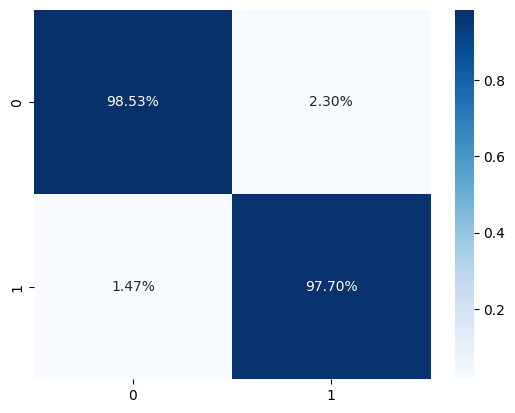

In [87]:
sns.heatmap(cm/np.sum(cm, axis=0), annot=True, 
            fmt='.2%', cmap='Blues')

In [30]:
from scipy.special import softmax

scores = eval_results['eval_raw_preds']
scores = softmax(scores, axis = 1)

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precisions, recalls, thresholds = precision_recall_curve(labels, scores[:,1])
area_under_curve = auc(recalls, precisions)

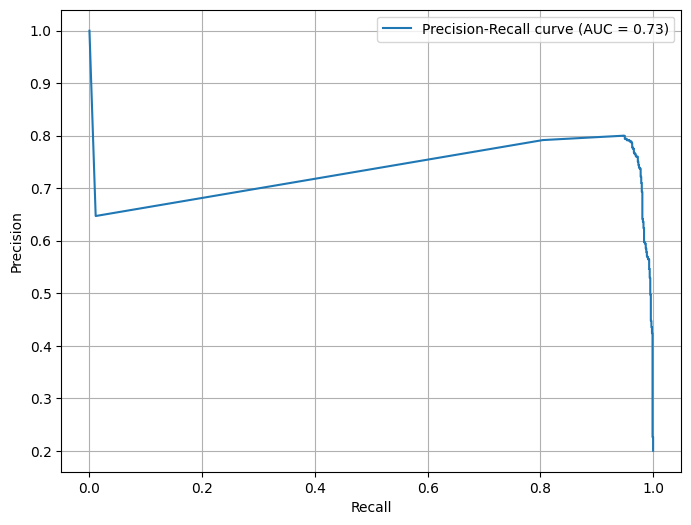

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve (AUC = {:.2f})'.format(area_under_curve))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('pr_curve.png')

In [33]:
true_pos = np.diag(cm) 
precision_per_cls = true_pos / np.sum(cm, axis=0)
recall_per_cls = true_pos / np.sum(cm, axis=1)

In [34]:
precision_per_cls

array([0.98733509, 0.79414226])

In [35]:
recall_per_cls

array([0.93831494, 0.95185557])

### Prediction

In [36]:
similarity_scores = scores[:,1]

In [37]:
test_df['similarity_score'] = similarity_scores

In [38]:
test_df

,text,label,similarity_score
0,"This month, the American people voted to prote...",0,0.008741
1,"For too long, women have been underrepresented...",0,0.000938
2,RT @POTUS: The choices we make today will dete...,0,0.000919
3,IÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢m proud to be the most pro-...,0,0.003400
4,There are more people in the U.S. workforce to...,0,0.000890
...,...,...,...
4980,Iran-backed Hamas terrorists have been holding...,1,0.991211
4981,Unconscionable and heartbreaking. We pray for ...,1,0.991211
4982,IÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢m relieved more hostages ha...,1,0.991211
4983,I'm incredibly relieved to hear that Abigail M...,1,0.991211


In [13]:
# temp_df = new_twits.copy()
# temp_df['label'] = pd.to_numeric(tweets_df['label'], errors='coerce')
# # Convert conflict_sentiment values which are different than 0 to 1
# temp_df['label'] = temp_df['label'].apply(lambda x: 0 if x == 0 else 1)
# temp_df_0 = temp_df[temp_df["label"] == 0]
# temp_df_1 = temp_df[temp_df["label"] == 1]
# df_sorted = temp_df_0.sort_values(by='upload_date')